# 🏡 **Helping Your Hosts:** Predicting Airbnb Host Ratings 🏨

---

> **Phase 3 Project: Classification**
>
> **Author:** Ben McCarty

---

---

**In a post-COVID world, hospitality faces challenges as travel restrictions are imposed and lifted (and then re-imposed).** Travel and tourism came to a crashing halt in 2020 and still face challenges in returning to pre-2020 business levels.

As restless travelers look to escape the confines of their homes, they expect the same high-quality services and experiences as pre-COVID. Competition within the hospitality industry is stronger than ever, putting more pressure on businesses to keep and grow their customer base.

**The main performance metric for every company involved in hospitality is guest satisfaction.** If a guest isn't satisfied, they are not likely to return for another visit and may share their experience with others, pushing away potential business.

Airbnb hosts face the same challenges as traditional hotels in these aggressive and challenging market conditions. In order to maximize their profitability and to distinguish themselves from traditional hotels, **Airbnb needs to know which aspects of a host property are the strongest predictors of whether a guest will give a satisfaction score of 4.8 or higher (out of 5).**

With this question in mind, I obtained data about Airbnb host properties from the [Inside Airbnb project](http://insideairbnb.com/get-the-data.html#:~:text=Washington%2C%20D.C.%2C%20District%20of%20Columbia%2C%20United%20States) for the Washington, D.C. area. The dataset includes details about the hosts themselves; property details (bedrooms, bathrooms, property types); and reservation availability.

**Once I have the data readied, I will use machine learning modeling techniques to determine my most important features for the region.** Then I will provide my final recommendations on what Airbnb should do to maximize the likelihood of their hosts obtaining a score of 4.8 or greater.

---

# 📂 **Imports and Settings**

In [626]:
## Data Handling
import pandas as pd
import numpy as np

## Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact_manual
import missingno

## Scikit-Learn
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config
# set_config(display='diagram')

## Settings
from IPython.display import display
%matplotlib inline
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 100)

In [627]:
## Personal functions
import clf_functions.functions as cf

## Tools to reload personal functions when called - prevents errors
%load_ext autoreload
%autoreload 1
%aimport clf_functions.functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ✅ Show Visualizations Setting

In [628]:
## Setting to control whether or not to show visualizations
show_visualizations = False

# 📖 **Read Data**

In [629]:
## Reading data and saving to a DataFrame

source = 'data/listings.csv.gz'
data = pd.read_csv(source)
data.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3686,https://www.airbnb.com/rooms/3686,20210710190002,2021-07-11,Vita's Hideaway,IMPORTANT NOTES<br />* Carefully read and be s...,We love that our neighborhood is up and coming...,https://a0.muscache.com/pictures/61e02c7e-3d66...,4645,https://www.airbnb.com/users/show/4645,Vita,2008-11-26,"Washington D.C., District of Columbia, United ...","I am a literary scholar, teacher, poet, vegan ...",within a day,80%,75%,f,https://a0.muscache.com/im/users/4645/profile_...,https://a0.muscache.com/im/users/4645/profile_...,Anacostia,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Washington, District of Columbia, United States",Historic Anacostia,nan,38.86,-76.99,Private room in house,Private room,1,nan,1 private bath,1.00,1.00,"[""First aid kit"", ""Long term stays allowed"", ""...",$55.00,2,365,2,2,365,365,2.00,365.00,nan,t,1,31,61,336,2021-07-11,75,3,0,2014-06-22,2021-01-12,4.59,4.71,4.44,4.89,4.82,3.80,4.58,NaN,f,2,0,2,0,0.87
1,3943,https://www.airbnb.com/rooms/3943,20210710190002,2021-07-11,Historic Rowhouse Near Monuments,Please contact us before booking to make sure ...,This rowhouse is centrally located in the hear...,https://a0.muscache.com/pictures/432713/fab7dd...,5059,https://www.airbnb.com/users/show/5059,Vasa,2008-12-12,"Washington, District of Columbia, United States",I have been living and working in DC for the l...,within a few hours,100%,29%,f,https://a0.muscache.com/im/pictures/user/8ec69...,https://a0.muscache.com/im/pictures/user/8ec69...,Eckington,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Washington, District of Columbia, United States","Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.91,-77.00,Private room in townhouse,Private room,2,nan,1.5 shared baths,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",nan,t,9,39,69,344,2021-07-11,429,0,0,2010-08-08,2018-08-07,4.82,4.89,4.91,4.94,4.90,4.54,4.74,NaN,f,2,0,2,0,3.22
2,4529,https://www.airbnb.com/rooms/4529,20210710190002,2021-07-11,Bertina's House Part One,This is large private bedroom with plenty of...,Very quiet neighborhood and it is easy accessi...,https://a0.muscache.com/pictures/86072003/6709...,5803,https://www.airbnb.com/users/show/5803,Bertina'S House,2008-12-30,"Washington, District of Columbia, United States","I am an easy going, laid back person who loves...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/5803/profile_...,https://a0.muscache.com/im/users/5803/profile_...,Eastland Gardens,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Washington, District of Columbia, United States","Eastland Gardens, Kenilworth",nan,38.91,-76.94,Private room

In [630]:
## Checking number of rows and columns
data.shape

(8033, 74)

---

> The initial read of the dataset shows there are 74 features and 8,033 entries. A quick glance at the `.head()` gives a sample of the entries, showing that some of the features are not relevant to my analysis.
>
> I need to get a better idea of the statistics for the dataset, especially any missing values and the datatypes for each column. I need to pre-process this data before I can perform any modeling.

---

# 👨‍💻 **Interactive Investigation**

---

> To increase accessibility to the data, **I include a widget to allow the user to sort through the data interactively.** I use [**Jupyter Widgets**](https://ipywidgets.readthedocs.io/en/latest/index.html) to create this interactive report.
>
>**To use:** select which column by which you would like to sort from the dropdown menu, then click the "Run Interact" button.
>
>***Note about 'Drop_Cols' and Cols:*** these keyword arguments are used to allow the user to drop specific columns.
>
> **Only click the "Drop_Cols" option when specifying "Cols"!** Otherwise it will cause an error.
>
>The 'Cols' dropdown menu does not affect the resulting report; the data is filtered from the report prior to displaying the results. 
>
>I chose to include this option for flexibility and adaptability, but it does have the unintended consequence of creating another drop-down menu. Please ignore this menu, as it does not provide any additional functionality. For future work, I will disable the menu to prevent confusion.

---

In [631]:
## Running report on unfiltered dataset

interact_manual(cf.sort_report, Sort_by=list(cf.report_df(data).columns),
                Source=source);

interactive(children=(Text(value='data/listings.csv.gz', description='Source'), Dropdown(description='Sort_by'…

In [632]:
data.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3686,https://www.airbnb.com/rooms/3686,20210710190002,2021-07-11,Vita's Hideaway,IMPORTANT NOTES<br />* Carefully read and be s...,We love that our neighborhood is up and coming...,https://a0.muscache.com/pictures/61e02c7e-3d66...,4645,https://www.airbnb.com/users/show/4645,Vita,2008-11-26,"Washington D.C., District of Columbia, United ...","I am a literary scholar, teacher, poet, vegan ...",within a day,80%,75%,f,https://a0.muscache.com/im/users/4645/profile_...,https://a0.muscache.com/im/users/4645/profile_...,Anacostia,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Washington, District of Columbia, United States",Historic Anacostia,nan,38.86,-76.99,Private room in house,Private room,1,nan,1 private bath,1.00,1.00,"[""First aid kit"", ""Long term stays allowed"", ""...",$55.00,2,365,2,2,365,365,2.00,365.00,nan,t,1,31,61,336,2021-07-11,75,3,0,2014-06-22,2021-01-12,4.59,4.71,4.44,4.89,4.82,3.80,4.58,NaN,f,2,0,2,0,0.87
1,3943,https://www.airbnb.com/rooms/3943,20210710190002,2021-07-11,Historic Rowhouse Near Monuments,Please contact us before booking to make sure ...,This rowhouse is centrally located in the hear...,https://a0.muscache.com/pictures/432713/fab7dd...,5059,https://www.airbnb.com/users/show/5059,Vasa,2008-12-12,"Washington, District of Columbia, United States",I have been living and working in DC for the l...,within a few hours,100%,29%,f,https://a0.muscache.com/im/pictures/user/8ec69...,https://a0.muscache.com/im/pictures/user/8ec69...,Eckington,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Washington, District of Columbia, United States","Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.91,-77.00,Private room in townhouse,Private room,2,nan,1.5 shared baths,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",nan,t,9,39,69,344,2021-07-11,429,0,0,2010-08-08,2018-08-07,4.82,4.89,4.91,4.94,4.90,4.54,4.74,NaN,f,2,0,2,0,3.22
2,4529,https://www.airbnb.com/rooms/4529,20210710190002,2021-07-11,Bertina's House Part One,This is large private bedroom with plenty of...,Very quiet neighborhood and it is easy accessi...,https://a0.muscache.com/pictures/86072003/6709...,5803,https://www.airbnb.com/users/show/5803,Bertina'S House,2008-12-30,"Washington, District of Columbia, United States","I am an easy going, laid back person who loves...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/5803/profile_...,https://a0.muscache.com/im/users/5803/profile_...,Eastland Gardens,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Washington, District of Columbia, United States","Eastland Gardens, Kenilworth",nan,38.91,-76.94,Private room

---

> After reviewing my data, I see there are several features that contain irrelevant entries (URLs, source data, meta data) or values that are too complicated for simple processing (such as host and listing descriptions).
>
> I will drop these columns for the second report to review the remaining data for further processing.

---

In [633]:
## Specifying columns to drop

drop = ['id', 'host_id', 'name', 'description', 'neighborhood_overview', 'host_name',
        'host_about', 'host_location', 'neighbourhood', 'property_type',
        'listing_url', 'scrape_id', 'last_scraped', 'picture_url','host_url',
        'host_thumbnail_url','host_picture_url','calendar_last_scraped']

In [634]:
df = data.drop(columns=drop).copy()
df

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-11-26,within a day,80%,75%,f,Anacostia,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,nan,38.86,-76.99,Private room,1,nan,1 private bath,1.00,1.00,"[""First aid kit"", ""Long term stays allowed"", ""...",$55.00,2,365,2,2,365,365,2.00,365.00,nan,t,1,31,61,336,75,3,0,2014-06-22,2021-01-12,4.59,4.71,4.44,4.89,4.82,3.80,4.58,NaN,f,2,0,2,0,0.87
1,2008-12-12,within a few hours,100%,29%,f,Eckington,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.91,-77.00,Private room,2,nan,1.5 shared baths,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",nan,t,9,39,69,344,429,0,0,2010-08-08,2018-08-07,4.82,4.89,4.91,4.94,4.90,4.54,4.74,NaN,f,2,0,2,0,3.22
2,2008-12-30,NaN,NaN,NaN,f,Eastland Gardens,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",nan,38.91,-76.94,Private room,4,nan,1 shared bath,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Keypad"", ...",$54.00,30,180,30,30,180,180,30.00,180.00,nan,t,29,59,89,179,102,0,0,2014-09-23,2019-07-05,4.66,4.80,4.60,4.93,4.93,4.51,4.83,NaN,f,1,0,1,0,1.23
3,2009-01-26,within a few hours,100%,78%,t,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",nan,38.91,-76.99,Private room,1,nan,3 baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",$99.00,2,365,2,2,365,365,2.00,365.00,nan,t,0,0,0,146,31,0,0,2012-02-13,2016-09-22,4.74,4.68,4.89,4.93,4.93,4.21,4.64,NaN,f,3,0,3,0,0.27
4,2009-01-13,within a few hours,100%,17%,f,Adams Morgan,4.00,4.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",nan,38.92,-77.04,Entire home/apt,3,nan,1 bath,1.00,1.00,"[""Window guards"", ""Cooking basics"", ""First aid...",$86.00,5,150,5,23,150,150,8.80,150.00,nan,t,7,32,62,121,95,0,0,2010-07-30,2020-03-05,4.54,4.75,4.17,4.83,4.84,4.91,4.47,NaN,f,2,1,1,0,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8028,2020-08-03,NaN,NaN,NaN,f,Southeast Washington,0.00,0.00,"['email', 'phone']",t,f,"Congress Heights, Bellevue, Washington Highlands",nan,38.83,-77.00,Entire home/apt,8,nan,1 bath,3.00,3.00,"[""First aid kit"", ""Dedicated workspace"", ""Smok...",$400.00,2,2,2,2,1125,1125,2.00,"1,125.00",nan,t,17,43,73,348,0,0,0,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,t,1,1,0,0,nan
8029,2020-07-29,within an hour,100%,83%,f,East Forest,125.00,125.00,"['email', 'phone']",t,t,"Howard University, Le Droit Park, Cardozo/Shaw",nan,38.92,-77.02,Entire home/apt,5,nan,2 baths,2.00,nan,"[""Cooking basics"", ""Lockbox"", ""Long term stays...",$198.00,90,365,90

In [635]:
## Creating updated interactive report

interact_manual(cf.sort_report, Drop_Cols = True, Cols = drop,
                Sort_by=list(cf.report_df(df).columns), Source=source);

interactive(children=(Text(value='data/listings.csv.gz', description='Source'), Dropdown(description='Sort_by'…

---

**Interpretation:**

> The report shows that the dataset has a big problem with missing values:
>
>* **100% Missing:**
>   * `neighbourhood_group_cleansed`
>   * `bathrooms`
>   * `calendar_updated`
></br></br>
> * **~100% Missing:**
>   * `license`
></br></br>
> * **26-39% Missing:**
>   * `host_about`
>   * `neighborhood_overview`
>   * `neighbourhood`
>   * `host_response_time`
>   * `host_response_rate`
>   * `review_scores_value`
>   * `review_scores_checkin`
>   * `review_scores_location`
>   * `review_scores_accuracy`
>   * `review_scores_communication`
>   * `review_scores_cleanliness`
>   * `host_acceptance_rate`
>   * `reviews_per_month`
>   * `first_review`
>   * `review_scores_rating`
>   * `last_review`

---

**Handling the Missing Values**

> I will need to address these missing values before processing with the modeling. A few options include:
>
>* **Filling with the string "missing"** to indicate the value was missing.
>   * Pro: *I would be able to treat "missing" as a distinct category and use it for modeling as well.*
>   * Con: *Does not add substantial value to the features missing large amounts of missing data.*</br></br>
>
>* **Dropping the rows with missing values.**
>   * Pro: *Reduces the number of features used in modeling, reducing complexity/runtime.*
>   * Con: *May cause the model model to overfit when presented with different datasets that include the missing data/features.*</br>

**Due to the large percentages of features and properties that are missing data, I feel it is best to drop those features and property entries that are missing values instead of attempting to fill in the gaps.**

---

---

**MissingNo**

> To get a better idea of the missing values, I create a visual of the values via the 'Missingno' package. This visualization package includes several options for visualizing the missing data.
</br></br>
> *Note: please set the "show_visualizations" variable to "True" to show these visualizations. By default they are disabled due to time required for processing.*

---

In [636]:
## Visually inspecting missing values
if show_visualizations == True:
    missingno.bar(data, labels=True);

In [637]:
## Visually inspecting missing values
if show_visualizations == True:
    missingno.matrix(data, labels=True);

---

> Based on this visualization, I see that **there is a consistent trend in missing values for review scores:** if a row is missing one review score, it seems to be missing all of them.
>
> Additionally, **there are many missing values for the response time, response rate, and acceptance rate.** I want to use these columns in my classification, so I will need to replace those missing values.
>
> After reviewing these details, **I feel more comfortable with the option of dropping those rows with missing review values.** I will drop the values as part of my overall classification process.

---

# 🧼 **Data Cleaning and EDA**

---

**Cleaning Process**

> To begin the cleaning process, I will:
>   * Drop the rows missing values for the target feature
>   * Drop features missing 98-100% of values

**Processing Remaining Missing Values**

> Instead of performing any manual updates to the remaining values, I will test different imputation methods as part of my modeling pipeline. </br></br>
> Potential methods would include:
>   * Imputing the string "MISSING"
>   * Imputing the most frequent value for string values
>   * Using the mean, median, or mode for numeric datatypes
>
> The benefit of including this step in a pipeline is that I will be able to include these different methods in a GridSearchCV as part of my hyperparameter turning steps.

---

## Dropping Rows Without Target Value

In [638]:
## Calculating number of missing values for target feature
df['review_scores_rating'].isna().sum()

2207

In [639]:
## Identifying row indices
nan_index = df['review_scores_rating'].isna()
nan_index

0       False
1       False
2       False
3       False
4       False
        ...  
8028     True
8029     True
8030     True
8031     True
8032     True
Name: review_scores_rating, Length: 8033, dtype: bool

In [640]:
## Dropping rows by index and resetting index
df = df.drop(df[nan_index].index)
df.reset_index(drop=True, inplace=True)
df

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-11-26,within a day,80%,75%,f,Anacostia,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,nan,38.86,-76.99,Private room,1,nan,1 private bath,1.00,1.00,"[""First aid kit"", ""Long term stays allowed"", ""...",$55.00,2,365,2,2,365,365,2.00,365.00,nan,t,1,31,61,336,75,3,0,2014-06-22,2021-01-12,4.59,4.71,4.44,4.89,4.82,3.80,4.58,NaN,f,2,0,2,0,0.87
1,2008-12-12,within a few hours,100%,29%,f,Eckington,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.91,-77.00,Private room,2,nan,1.5 shared baths,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",nan,t,9,39,69,344,429,0,0,2010-08-08,2018-08-07,4.82,4.89,4.91,4.94,4.90,4.54,4.74,NaN,f,2,0,2,0,3.22
2,2008-12-30,NaN,NaN,NaN,f,Eastland Gardens,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",nan,38.91,-76.94,Private room,4,nan,1 shared bath,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Keypad"", ...",$54.00,30,180,30,30,180,180,30.00,180.00,nan,t,29,59,89,179,102,0,0,2014-09-23,2019-07-05,4.66,4.80,4.60,4.93,4.93,4.51,4.83,NaN,f,1,0,1,0,1.23
3,2009-01-26,within a few hours,100%,78%,t,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",nan,38.91,-76.99,Private room,1,nan,3 baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",$99.00,2,365,2,2,365,365,2.00,365.00,nan,t,0,0,0,146,31,0,0,2012-02-13,2016-09-22,4.74,4.68,4.89,4.93,4.93,4.21,4.64,NaN,f,3,0,3,0,0.27
4,2009-01-13,within a few hours,100%,17%,f,Adams Morgan,4.00,4.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",nan,38.92,-77.04,Entire home/apt,3,nan,1 bath,1.00,1.00,"[""Window guards"", ""Cooking basics"", ""First aid...",$86.00,5,150,5,23,150,150,8.80,150.00,nan,t,7,32,62,121,95,0,0,2010-07-30,2020-03-05,4.54,4.75,4.17,4.83,4.84,4.91,4.47,NaN,f,2,1,1,0,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,2014-06-03,within a few hours,100%,75%,f,Northeast Washington,0.00,0.00,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.92,-77.01,Entire home/apt,3,nan,1 bath,1.00,2.00,"[""HDTV with Amazon Prime Video, Netflix"", ""Fir...",$104.00,2,24,2,3,24,24,2.30,24.00,nan,t,20,50,80,354,1,1,1,2021-07-05,2021-07-05,5.00,5.00,5.00,5.00,5.00,5.00,5.00,NaN,f,1,1,0,0,1.00
5822,2012-06-13,within an hour,100%,100%,f,Northwest Washington,0.00,0.00,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.91,-77.01,Entire home/a

In [641]:
## Reviewing results
# cf.report_df(df).sort_values('null_sum', ascending=False)
f"There are {df['review_scores_rating'].isna().sum()} missing values."

'There are 0 missing values.'

## ❌ 🔎 Fixing Missing Values

❌ **Moving imputation to pipeline**

---

> This dataset is missing a significant number of values for different columns. **In order to perform any modeling, I will address these missing values first.**
>
> As described previously, I will drop those features and rows with high percentages of missing values. Then, I will be able to fill in the missing values for the 'beds'/'bedrooms’ features by cross-referencing the columns. If one of the rows is missing a value for one feature, but has a value for the other, I will simply fill in the missing value with the value from the other column.

---

In [642]:
# ## Dropping features with high percentages (25%+) of missing values

# percent_null = df.drop(columns='review_scores_rating').isna().sum()/len(df)
# drop_na_cols = percent_null[percent_null > .25].index
# drop_na_cols

In [643]:
# ## Creating new dataframe that does not include the features to drop
# df = df.drop(columns= drop_na_cols)
# df

In [644]:
# ## Inspecting values post-dropping
# cf.report_df(df).sort_values('null_sum', ascending=False)

## Filling Beds

---

> After dropping columns and rows with large percentages of missing values, I proceed to address the missing values in the 'Beds' and "Bedrooms" columns.
>
> As the values are similar between the two, I will compare the rows against each other. For each row, if there is a missing value in one column that is present in the other, I will fill the missing value with the value present in the other column.

---

In [645]:
## Filling missing values for 'beds' with values for 'bedrooms'
df['beds'].fillna(df['bedrooms'], inplace=True)
df['beds'].isna().sum()

## Filling missing values for 'bedrooms' with values for 'beds'
df['bedrooms'].fillna(df['beds'], inplace=True)

df['beds'].isna().sum(), df['bedrooms'].isna().sum()

(1, 1)

In [646]:
## Confirming reduction in missing values for 'beds' and 'bedrooms'

# rpt_clean  = cf.report_df(df)
# rpt_clean[rpt_clean['null_sum'] >0].sort_values('null_sum', ascending=False)

f"There are {df['beds'].isna().sum()} missing value(s) for `beds` and {df['bedrooms'].isna().sum()} missing value(s) for `bedrooms`."

'There are 1 missing value(s) for `beds` and 1 missing value(s) for `bedrooms`.'

In [647]:
## Inspecting row with missing value for "bed"
df['beds'][df['beds'].isna() >0], df['bedrooms'][df['bedrooms'].isna() >0]

(4782   nan
 Name: beds, dtype: float64,
 4782   nan
 Name: bedrooms, dtype: float64)

---

**Still Missing?**

> After cleaning the 'bed'/'bedroom' columns, there is one column containing the remaining missing values. I will fill these missing values later as part of my pipeline.

---

## Dropping Rows with 6+ Missing Values

In [648]:
# ## Removing rows with 6+ null values

# df = df[df.isna().sum(axis=1) < 6]
# df.head(5)

In [649]:
# ## Reviewing remaining missing values

# df.isna().sum()[df.isna().sum() > 0]

In [650]:
# cf.report_df(df)

---

> Now that I dropped most of my missing values, I review the distribution of my ratings.
>
> **My main focus is to review the split of values at the 4.8 mark.** This split will give me an idea of the performance of the host properties in my data set.

---


In [651]:
## Reviewing the total ratings at or above the threshold of 4.8

len(df['review_scores_rating'][df['review_scores_rating'] >= 4.8])/ len(df)

0.6191211809131479

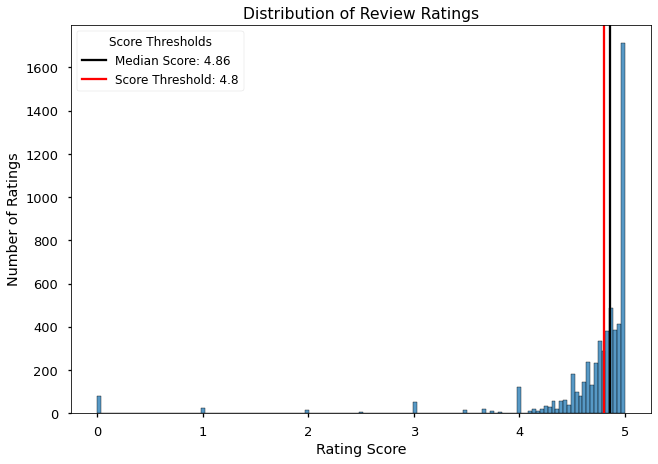

In [652]:
## Visualizing the overall distribution of ratings

ax = sns.histplot(data = df['review_scores_rating'], bins = 'auto')

ax.set(title = 'Distribution of Review Ratings',
       xlabel = 'Rating Score', ylabel = 'Number of Ratings')

median = df['review_scores_rating'].median()
ax.axvline(median, label = f'Median Score: {median}', color='k')
ax.axvline(4.8, label = 'Score Threshold: 4.8', color='red')
ax.legend(fontsize= 'large',title = 'Score Thresholds',
          title_fontsize = 'large');

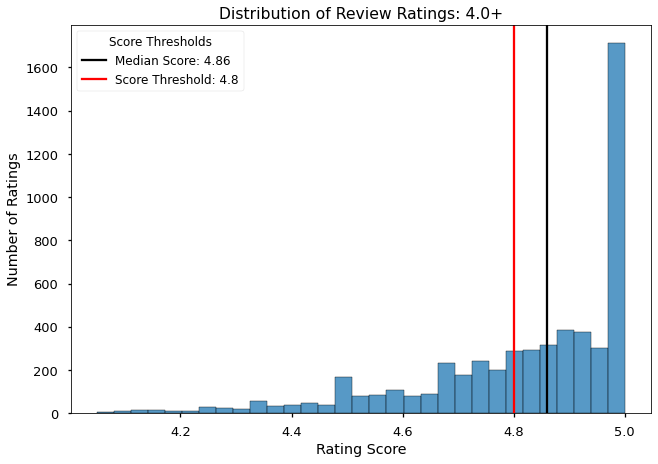

In [653]:
## Zooming in on 4.0-5.0 range
ax = sns.histplot(data = df['review_scores_rating'][df['review_scores_rating']>4], bins = 'auto')

ax.set(title = 'Distribution of Review Ratings: 4.0+',
       xlabel = 'Rating Score', ylabel = 'Number of Ratings')

median = df['review_scores_rating'].median()
ax.axvline(median, label = f'Median Score: {median}', color='k')
ax.axvline(4.8, label = 'Score Threshold: 4.8', color='red')
ax.legend(fontsize= 'large',title = 'Score Thresholds',
          title_fontsize = 'large');

---

**Observations and Next Steps**

> Based on the results above, I see that **62% of the reviews are at or above the target threshold of 4.8.**
>
> These scores show that there's a close balance of scores that are meeting our threshold. However, this imbalance may still impair the performance of my future model.
>
> To address this imbalance, I will later use the SMOTE technique to oversample the minority class.

---

# 🔨 **Fixing Feature Formatting**

---

> Now that I addressed most of my missing values, I will process the remaining features and columns to allow for the modeling process.
>
> I perform the following changes:</br></br>

> **Data Conversions:**
>   * **`T/F`:** Any features with 't'/'f' values need to be converted to 1/0, respectively.
>   * **`price`:** The `price` feature consists of string values; to use it properly, I will convert the values to the float datatype.
>   * **`room_type`:** Converting to simpler string values.
>   * **`neighbourhood_cleansed`:** The 'neighbourhood_cleansed' feature values are a single string of neighborhoods. I will split these strings into boolean features for each neighborhood. </br></br>

> **Feature Engineering:**
>   * `years_hosting`: Using the year in which the host started in the `host_since` feature to calculate the number of years as a host.
>   * `bathrooms_text`: Converting to a new `num_bathrooms` numeric feature.

---

## Converting True/False Columns to Binary Values

In [654]:
df.select_dtypes('O')

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,bathrooms_text,amenities,price,has_availability,first_review,last_review,license,instant_bookable
0,2008-11-26,within a day,80%,75%,f,Anacostia,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,Private room,1 private bath,"[""First aid kit"", ""Long term stays allowed"", ""...",$55.00,t,2014-06-22,2021-01-12,NaN,f
1,2008-12-12,within a few hours,100%,29%,f,Eckington,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Private room,1.5 shared baths,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",$70.00,t,2010-08-08,2018-08-07,NaN,f
2,2008-12-30,NaN,NaN,NaN,f,Eastland Gardens,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",Private room,1 shared bath,"[""Cooking basics"", ""First aid kit"", ""Keypad"", ...",$54.00,t,2014-09-23,2019-07-05,NaN,f
3,2009-01-26,within a few hours,100%,78%,t,Ivy City,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",Private room,3 baths,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",$99.00,t,2012-02-13,2016-09-22,NaN,f
4,2009-01-13,within a few hours,100%,17%,f,Adams Morgan,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",Entire home/apt,1 bath,"[""Window guards"", ""Cooking basics"", ""First aid...",$86.00,t,2010-07-30,2020-03-05,NaN,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,2014-06-03,within a few hours,100%,75%,f,Northeast Washington,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Entire home/apt,1 bath,"[""HDTV with Amazon Prime Video, Netflix"", ""Fir...",$104.00,t,2021-07-05,2021-07-05,NaN,f
5822,2012-06-13,within an hour,100%,100%,f,Northwest Washington,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Entire home/apt,1 bath,"[""Single level home"", ""Keypad"", ""Dining table""...",$96.00,t,2021-07-05,2021-07-05,NaN,f
5823,2011-02-17,within an hour,100%,99%,t,NaN,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",Entire home/apt,1.5 baths,"[""Cooking basics"", ""First aid kit"", ""Toaster"",...",$236.00,t,2021-07-03,2021-07-06,NaN,t
5824,2019-06-19,within a few hours,88%,100%,f,Northwest Washington,"['email', 'phone']",t,f,"Friendship Heights, American University Park, ...",Entire home/apt,1 bath,"[""Cooking basics"", ""First aid kit"", ""Mosquito ...",$139.00,t,2021-07-05,2021-07-05,NaN,f


In [655]:
t_f_col = df.loc[:,(df == 't').any()].columns
t_f_col

Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'has_availability', 'instant_bookable'],
      dtype='object')

In [656]:
## Converting t/f to 1/0, respectively
df.loc[:,t_f_col] = df.loc[:,t_f_col].replace({ 't' : 1, 'f' : 0})

In [657]:
df.loc[:,t_f_col]

,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable
0,0.00,1.00,1.00,1,0
1,0.00,1.00,1.00,1,0
2,0.00,1.00,1.00,1,0
3,1.00,1.00,1.00,1,0
4,0.00,1.00,1.00,1,0
...,...,...,...,...,...
5821,0.00,1.00,1.00,1,0
5822,0.00,1.00,1.00,1,0
5823,1.00,1.00,1.00,1,1
5824,0.00,1.00,0.00,1,0


In [658]:
## Verifying results
cf.report_df(df[t_f_col])

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
host_is_superhost,10,0.00,float64,2,"5,816.00",0.33,0.47,0.00,0.00,0.00,1.00,1.00
host_has_profile_pic,10,0.00,float64,2,"5,816.00",1.00,0.03,0.00,1.00,1.00,1.00,1.00
host_identity_verified,10,0.00,float64,2,"5,816.00",0.82,0.39,0.00,1.00,1.00,1.00,1.00
has_availability,0,0.00,int64,2,"5,826.00",0.98,0.14,0.00,1.00,1.00,1.00,1.00
instant_bookable,0,0.00,int64,2,"5,826.00",0.37,0.48,0.00,0.00,0.00,1.00,1.00


## Converting Price to Float 

In [659]:
## Inspecting original feature
df['price']

0        $55.00
1        $70.00
2        $54.00
3        $99.00
4        $86.00
         ...   
5821    $104.00
5822     $96.00
5823    $236.00
5824    $139.00
5825     $67.00
Name: price, Length: 5826, dtype: object

In [660]:
## Converting each string value into a float
df['price'] = df['price'].map(lambda price: price[1:].replace(',','')).astype('float')
df['price']

0       55.00
1       70.00
2       54.00
3       99.00
4       86.00
        ...  
5821   104.00
5822    96.00
5823   236.00
5824   139.00
5825    67.00
Name: price, Length: 5826, dtype: float64

In [661]:
df['price'].head()

0   55.00
1   70.00
2   54.00
3   99.00
4   86.00
Name: price, dtype: float64

In [662]:
df['price'].describe()

count    5,826.00
mean       151.40
std        229.86
min          0.00
25%         77.00
50%        108.00
75%        164.00
max     10,000.00
Name: price, dtype: float64

## Creating "Years_Hosting"

---

> Since the 'host_since' feature is clearly a date, I will create a separate feature for how many years of activity for each host.
>
> ***Special Note:*** Due to the presence of a limited number of missing values, I will temporarily fill the missing values with a placeholder to create the features, then re-convert the placeholders to NaN values.

---

In [663]:
## Calculating initial number of missing values
df["host_since"].isna().sum()

10

In [664]:
## Identifying indices for missing values
host_since_nan = df["host_since"][df["host_since"].isna()].index
host_since_nan

Int64Index([5233, 5234, 5235, 5236, 5237, 5238, 5239, 5240, 5246, 5537], dtype='int64')

In [665]:
## Filling with placeholder value
df["host_since"] = df["host_since"].fillna('2000-01-01')
df["host_since"].isna().sum()

0

In [666]:
## Creating feature
df['years_hosting'] = df["host_since"].map(lambda x: 2021- int(x.split("-")[0]))
df['years_hosting']

0       13
1       13
2       13
3       12
4       12
        ..
5821     7
5822     9
5823    10
5824     2
5825     2
Name: years_hosting, Length: 5826, dtype: int64

In [667]:
## Confirm post-conversion results for origina missing rows
df.loc[host_since_nan, ["host_since", 'years_hosting']]

,host_since,years_hosting
5233,2000-01-01,21
5234,2000-01-01,21
5235,2000-01-01,21
5236,2000-01-01,21
5237,2000-01-01,21
5238,2000-01-01,21
5239,2000-01-01,21
5240,2000-01-01,21
5246,2000-01-01,21
5537,2000-01-01,21


In [668]:
## Converting back to missing values
df.loc[host_since_nan, ["host_since", 'years_hosting']] = np.nan
df.loc[host_since_nan, ["host_since", 'years_hosting']]

,host_since,years_hosting
5233,NaN,nan
5234,NaN,nan
5235,NaN,nan
5236,NaN,nan
5237,NaN,nan
5238,NaN,nan
5239,NaN,nan
5240,NaN,nan
5246,NaN,nan
5537,NaN,nan


In [669]:
## Confirming final value counts
df['years_hosting'].value_counts(dropna=False)

6.00     1226
5.00      961
7.00      803
8.00      641
4.00      492
9.00      379
3.00      351
2.00      292
10.00     227
0.00      142
1.00      138
11.00      79
12.00      66
13.00      19
nan        10
Name: years_hosting, dtype: int64

In [670]:
df['years_hosting'].describe()

count   5,816.00
mean        5.89
std         2.45
min         0.00
25%         5.00
50%         6.00
75%         7.00
max        13.00
Name: years_hosting, dtype: float64

---

> I successfully created the new feature to represent how long each host is active (up to 2021). I will be curious to see the impact of the years of experience on the overall rating at the end of my modeling process.

---

## Bathrooms_Text to Num_Bathrooms

---

> In the raw data, the original "bathrooms" feature was empty and was dropped as part of processing missing data.
>
> **My goal is to convert the "bathrooms_text" feature into a new "num_bathrooms" feature to indicate the number of bathrooms at a host property.**
>
> I assume the number of bathrooms would have an impact on the rating . More bathrooms could mean more space/comfort for the guest, but could also cause an increase in price.


---

In [671]:
## Inspecting the values for "bathrooms_text"
df['bathrooms_text'].value_counts(dropna=False)

1 bath              3226
1 shared bath        482
1 private bath       482
2 baths              476
1.5 baths            327
2.5 baths            298
1.5 shared baths     137
3.5 baths            104
2 shared baths        89
3 baths               83
2.5 shared baths      32
4 baths               30
4.5 baths             20
3 shared baths         8
0 baths                6
NaN                    4
0 shared baths         4
5.5 baths              3
5 baths                3
3.5 shared baths       2
6.5 baths              2
11 shared baths        2
5.5 shared baths       2
6 baths                2
Half-bath              1
Shared half-bath       1
Name: bathrooms_text, dtype: int64

In [672]:
## Inspecting the rows in which there are null values
df[df['bathrooms_text'].isna()]

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,years_hosting
20,2010-10-04,within a few hours,100%,25%,1.00,Logan Circle,1.00,1.00,"['email', 'phone', 'facebook', 'reviews']",1.00,0.00,"Dupont Circle, Connecticut Avenue/K Street",nan,38.91,-77.03,Entire home/apt,2,nan,NaN,1.00,1.00,"[""Cooking basics"", ""Lockbox"", ""Dedicated works...",195.00,3,365,3,3,365,365,3.00,365.00,nan,1,17,47,77,352,156,2,0,2015-09-21,2020-12-02,4.85,4.86,4.88,4.92,4.91,4.92,4.73,NaN,0,1,1,0,0,2.21,11.00
25,2009-01-26,within a few hours,100%,78%,1.00,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",1.00,1.00,"Ivy City, Arboretum, Trinidad, Carver Langston",nan,38.90,-76.99,Private room,1,nan,NaN,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",99.00,2,730,2,2,730,730,2.00,730.00,nan,1,4,13,18,197,10,0,0,2013-11-10,2016-08-27,4.89,4.40,4.90,4.90,4.70,4.10,4.50,NaN,0,3,0,3,0,0.11,12.00
26,2009-01-26,within a few hours,100%,78%,1.00,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",1.00,1.00,"Ivy City, Arboretum, Trinidad, Carver Langston",nan,38.91,-76.98,Private room,1,nan,NaN,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",99.00,2,730,2,2,730,730,2.00,730.00,nan,1,1,14,20,198,10,0,0,2015-05-15,2016-09-30,4.90,4.80,4.90,4.90,4.90,4.20,4.60,NaN,0,3,0,3,0,0.13,12.00
4782,2019-08-22,within an hour,100%,100%,0.00,U Street Corridor,0.00,0.00,"['email', 'phone']",1.00,1.00,"Howard University, Le Droit Park, Cardozo/Shaw",nan,38.92,-77.03,Hotel room,0,nan,NaN,nan,nan,"[""Bed sheets and pillows"", ""First aid kit"", ""O...",0.00,1,365,1,1,365,365,1.00,365.00,nan,1,0,0,0,0,33,19,7,2020-02-08,2021-06-24,4.36,4.45,4.24,4.30,4.39,4.52,4.52,NaN,0,3,0,0,2,1.90,2.00


In [673]:
## Filling null values with unique string ('Baths' not present otherwise)
df.loc[:,'bathrooms_text'].fillna('0 Baths', inplace=True)

## Verifying all null values are filled
df['bathrooms_text'].isna().sum()

0

In [674]:
## Reviewing updated values
df['bathrooms_text'].value_counts(dropna=False)

1 bath              3226
1 shared bath        482
1 private bath       482
2 baths              476
1.5 baths            327
2.5 baths            298
1.5 shared baths     137
3.5 baths            104
2 shared baths        89
3 baths               83
2.5 shared baths      32
4 baths               30
4.5 baths             20
3 shared baths         8
0 baths                6
0 shared baths         4
0 Baths                4
5.5 baths              3
5 baths                3
3.5 shared baths       2
6.5 baths              2
11 shared baths        2
5.5 shared baths       2
6 baths                2
Half-bath              1
Shared half-bath       1
Name: bathrooms_text, dtype: int64

In [675]:
## Splitting each string value and selecting the first element (representing the number of bathrooms)
df['num_bathrooms'] = df['bathrooms_text'].map(lambda x: x.split(' ')[0])
df['num_bathrooms'].value_counts()

1            4190
2             565
1.5           464
2.5           330
3.5           106
3              91
4              30
4.5            20
0              14
5.5             5
5               3
6               2
6.5             2
11              2
Shared          1
Half-bath       1
Name: num_bathrooms, dtype: int64

In [676]:
## Converting remaining string values to floats
df['num_bathrooms'] = df['num_bathrooms'].replace({'Shared': .05, "Half-bath": .05})
df['num_bathrooms'] = df['num_bathrooms'].astype(float)

In [677]:
df['num_bathrooms']

0      1.00
1      1.50
2      1.00
3      3.00
4      1.00
       ... 
5821   1.00
5822   1.00
5823   1.50
5824   1.00
5825   1.00
Name: num_bathrooms, Length: 5826, dtype: float64

In [679]:
df['num_bathrooms'].value_counts(dropna=False)

1.00     4190
2.00      565
1.50      464
2.50      330
3.50      106
3.00       91
4.00       30
4.50       20
0.00       14
5.50        5
5.00        3
0.05        2
6.50        2
11.00       2
6.00        2
Name: num_bathrooms, dtype: int64

In [682]:
## Inspecting rows where 'num_bathrooms' is zero to validate data

df[df['num_bathrooms'] ==0].head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,years_hosting,num_bathrooms
20,2010-10-04,within a few hours,100%,25%,1.00,Logan Circle,1.00,1.00,"['email', 'phone', 'facebook', 'reviews']",1.00,0.00,"Dupont Circle, Connecticut Avenue/K Street",nan,38.91,-77.03,Entire home/apt,2,nan,0 Baths,1.00,1.00,"[""Cooking basics"", ""Lockbox"", ""Dedicated works...",195.00,3,365,3,3,365,365,3.00,365.00,nan,1,17,47,77,352,156,2,0,2015-09-21,2020-12-02,4.85,4.86,4.88,4.92,4.91,4.92,4.73,NaN,0,1,1,0,0,2.21,11.00,0.00
25,2009-01-26,within a few hours,100%,78%,1.00,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",1.00,1.00,"Ivy City, Arboretum, Trinidad, Carver Langston",nan,38.90,-76.99,Private room,1,nan,0 Baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",99.00,2,730,2,2,730,730,2.00,730.00,nan,1,4,13,18,197,10,0,0,2013-11-10,2016-08-27,4.89,4.40,4.90,4.90,4.70,4.10,4.50,NaN,0,3,0,3,0,0.11,12.00,0.00
26,2009-01-26,within a few hours,100%,78%,1.00,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",1.00,1.00,"Ivy City, Arboretum, Trinidad, Carver Langston",nan,38.91,-76.98,Private room,1,nan,0 Baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",99.00,2,730,2,2,730,730,2.00,730.00,nan,1,1,14,20,198,10,0,0,2015-05-15,2016-09-30,4.90,4.80,4.90,4.90,4.90,4.20,4.60,NaN,0,3,0,3,0,0.13,12.00,0.00
467,2015-03-05,within a day,50%,0%,0.00,Dupont Circle,8.00,8.00,"['email', 'phone', 'reviews']",1.00,1.00,"Dupont Circle, Connecticut Avenue/K Street",nan,38.91,-77.04,Private room,2,nan,0 baths,1.00,1.00,"[""Long term stays allowed"", ""Essentials"", ""Hea...",80.00,1,1125,1,1,1125,1125,1.00,"1,125.00",nan,1,0,0,0,0,159,0,0,2016-07-06,2020-03-11,4.69,4.81,4.78,4.92,4.82,4.97,4.69,NaN,0,8,0,8,0,2.61,6.00,0.00
468,2015-03-05,within a day,50%,0%,0.00,Dupont Circle,8.00,8.00,"['email', 'phone', 'reviews']",1.00,1.00,"Dupont Circle, Connecticut Avenue/K Street",nan,38.91,-77.04,Private room,2,nan,0 baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Long t...",80.00,1,1125,1,1,1125,1125,1.00,"1,125.00",nan,1,0,0,0,0,231,0,0,2015-06-28,2020-01-20,4.59,4.75,4.74,4.82,4.79,4.95,4.64,NaN,0,8,0,8,0,3.14,6.00,0.00


In [ ]:
## Removing old column post-conversion

df = df.drop(columns = 'bathrooms_text')

In [ ]:
## Confirming removal

'bathrooms_text' in df.columns

---

> My review of the original bathroom text for the zero bathrooms column shows that the listings are associated with a private room. This would make sense as the listings may not include an option such as a shared bath, etc..
>
> Additionally I did fill 9 instances of missing values with "0 Baths," which would contribute slightly to this count.
>
> Overall, I feel the data is valid and I will use it for my modeling.

---

## Cleaning Room_Type

---

>  In order to use “room_type” as a categorical variable, I convert the values to standardized strings. This allows me to perform one-hot encoding as part of my pre-modeling steps below.

---

In [ ]:
## Reviewing pre-existing values

df['room_type'].value_counts()

In [ ]:
## Replacing values with updated strings

replace_rooms = {'Entire home/apt': 'entire_home', 
                 'Private room': 'private_room',
                 'Shared room': 'shared_room',
                 'Hotel room': 'hotel_room'
                }

df['room_type'].replace(replace_rooms, inplace=True)
df['room_type'].value_counts(dropna=False)

## Binarizing Columns

---

> The current values for "neighbourhood_cleansed", 'host_verifications', and 'amenities' are  single string values. **For each feature, I will separate each string into distinct, unique values and convert them into a binary column to represent whether or not that value is included in the listing, then drop the old column.**

---

### Neighbourhood_Cleansed

In [ ]:
## Inspecting feature
df.loc[:,'neighbourhood_cleansed'][:5]

In [ ]:
df.loc[:,'neighbourhood_cleansed'][0]

In [ ]:
## Splitting string value between neighborhoods

unique_nghbrhd = list(set(','.join(df['neighbourhood_cleansed']).split(',')))
unique_nghbrhd

In [ ]:
## Cleaning names and creating T/F binary columns

for ngbrhd in unique_nghbrhd:
    
    ngbrhd = ngbrhd.replace("'", "")
    
    if ngbrhd[0] == ' ':
        ngbrhd = ngbrhd[1:]
    
    df[ngbrhd] = df['neighbourhood_cleansed'].str.contains(ngbrhd).astype(int)

In [ ]:
## Confirming results
df.columns[-20:]

In [ ]:
## Confirming removal of leading spaces and any quotes

df.columns[-20:][0][:3]

### Host_Verifications

In [ ]:
## Inspecting values
df['host_verifications'][:5]

In [ ]:
## Inspecting the first five items of the second row

df.loc[:,'host_verifications'][1][:5]

In [ ]:
## Splitting string value between verifications

unique_verif = list(set(','.join(df['host_verifications']).split(',')))
unique_verif

In [ ]:
## Cleaning names and creating T/F binary columns

for verification in unique_verif:
    
    if len(verification) > 2:
        
        verification = verification.replace('[', '').replace(']', '').\
        replace("'", '').replace('"', '')

    if verification[0] == ' ':
        verification = verification[1:]

        df[verification] = df['host_verifications'].str.\
                            contains(verification).astype(int)

In [ ]:
df.columns

---

> At this point, I successfully processed the 'host_verification' feature into distinct categories for modeling.

---

### Amenities


In [ ]:
## Inspecting values
df['amenities'][:5]

In [ ]:
## Inspecting the first five items of the second row

df.loc[:,'amenities'][1][:5]

In [ ]:
## Splitting string value between items

unique_amenities = list(set(','.join(df['amenities']).split(',')))
unique_amenities

In [ ]:
## Cleaning names and creating T/F binary columns

for amenity in unique_amenities:
           
    amenity = amenity.replace('[', '').replace(']', '').\
    replace("'", '').replace('"', '')

    if amenity[0] == ' ':
        amenity = amenity[1:]

        df[amenity] = df['amenities'].str.\
                            contains(amenity).astype(int)

In [ ]:
df.columns

# 🔬 **Pre-Pipeline Review**

In [ ]:
## Review remaining data
df.head(3)

In [ ]:
## Removing columns with no impact on modeling

df.drop(columns = ['host_since', 'host_neighbourhood', 'amenities', 'host_is_superhost'], inplace=True)

In [ ]:
## Final review

df.describe()

# **Binarizing Target Feature**

---

> In order to achieve the goal of identifying the most important features for review scores, I convert the target variable 'review_scores_rating" into binary values to represent if the score is below the threshold of 4.8 (represented as a '0') and above the threshold (represented as a '0').

---

In [ ]:
## Using np.select to reassign target values based on conditional evaluations

cond = [df['review_scores_rating'] >= 4.8,
        df['review_scores_rating'] < 4.8]

choice = [1,0]

df['review_scores_rating'] = np.select(cond, choice, 0)

In [ ]:
## Reviewing results to confirm only 0/1 values and inspecting balance
df['review_scores_rating'].value_counts(dropna=False, normalize=True, sort=False)

---

> After processing the missing values and formatting the data, the values are properly converted into 0/1 values and the class balance is maintained.

---

# 🪓 **Train/Test Split**

---

> Before I run any further pre-processing, I split my data into training and test sets to allow me to test my model's performance.
>
> **Since my target feature is converted into binary values, I will use the "stratify" parameter in my train/test split, preserving the class balance when I split my data.** This will be key for proper evaluation of my models.

---

In [ ]:
## Specifying features and target columns for dataset
target = 'review_scores_rating'

X = df.drop(columns = target).copy()
y = df[target].copy()

In [ ]:
## Confirming same number of rows
X.shape[0] == y.shape[0]

In [ ]:
## Splitting to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, 
                                                    random_state=42, 
                                                    stratify=y)

# 🚿 **Preprocessing Pipeline**

---

>  Before I start my modeling processes, I convert my remaining categorical column via one-hot encoding and perform standardization on my numeric columns. Once my columns are properly converted, I will save them as new dataframes and use them in my modeling.

---

In [ ]:
## Specifying numeric columns for preprocessing
num_cols = X_train.select_dtypes(include=[int, float]).columns.to_list()
# num_cols

In [ ]:
## Specifying categorical columns for preprocessing
cat_cols = ['room_type']
cat_cols

In [ ]:
## Checking missing X-values for imputation
X_train.isna().sum()[X_train.isna().sum() > 0]

## Runnning Preprocessor

In [ ]:
## Creating ColumnTransformer and sub-transformers for imputation and encoding


### --- Creating column transformers --- ###

# Filling missing values in "Beds" and "Bedrooms"
miss_num_transformer = SimpleImputer(strategy='mean')

## Encoding categoricals - ignoring errors to prevent issues w/ test set
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)


### --- Creating column pipelines --- ###

cat_pipe = Pipeline(steps=[('ohe', categorical_transformer)])

num_pipe = Pipeline(steps=[('imputer', miss_num_transformer),
                           ('scaler', StandardScaler())])

## Instantiating the ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[('nums', num_pipe, num_cols),
                  ('cats', cat_pipe, cat_cols)])

preprocessor

In [ ]:
## Fitting feature preprocessor
preprocessor.fit(X_train)

## Getting feature names from OHE
ohe_cat_names = preprocessor.named_transformers_['cats'].named_steps['ohe'].get_feature_names(cat_cols)

## Generating list for column index
final_cols = [*num_cols, *ohe_cat_names]

In [ ]:
## Transform the data via the ColumnTransformer preprocessor

X_train_tf = preprocessor.transform(X_train)
X_train_tf_df = pd.DataFrame(X_train_tf, columns=final_cols, index=X_train.index)

X_test_tf = preprocessor.transform(X_test)
X_test_tf_df = pd.DataFrame(X_test_tf, columns=final_cols, index=X_test.index)

display(X_train_tf_df.head(5),X_test_tf_df.head(5))

# 📊 **Baseline Model**

In [ ]:
## Creating baseline classifier model

base = DummyClassifier(strategy='stratified', random_state = 42)

base.fit(X_train_tf_df, y_train)

cf.evaluate_classification(base,X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test, 
                           metric = 'accuracy')

In [ ]:
## Saving the baseline scores for later comparisons

base_train_score, base_test_score, base_train_ll, base_test_ll = \
cf.model_scores(base, X_train_tf_df, y_train, X_test_tf_df, y_test)

base_train_score, base_test_score, base_train_ll, base_test_ll

---

**Interpretation**

> The baseline model is designed to be a poor-performer: the results are intended to be be close to .5 for most metrics, indicating the model is not performing better than simply guessing one result or the other.
>
> I use this model as a comparison point to judge the performance of my other models.

---

#  📊 **Logistic Regression Model**

In [ ]:
clf = LogisticRegression(tol = 1e-3, C = 10, penalty = "l1", solver = 'saga', 
                         max_iter=1000, class_weight='balanced', n_jobs=-1,
                         random_state = 42)

clf.fit(X_train_tf_df, y_train)

cf.evaluate_classification(clf, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'accuracy')

In [ ]:
clf.coef_.flatten().shape

In [ ]:
logreg_coefs = pd.Series(clf.coef_.flatten(),
                         index= X_train_tf_df.columns)\
                            .sort_values(ascending = False)
logreg_coefs

In [ ]:
pd.concat([logreg_coefs.head(10),logreg_coefs.tail(10)]).plot(kind='barh')

# logreg_coefs.head(10).plot(kind='barh')
# logreg_coefs.tail(10).plot(kind='barh')

top: table, private room
bottom: shared rooms, # beds/room

Privacy being a big impact - private vs.shared rooms; certain amenities perform better than others.

Future exploration:

* stove: could be like renting a room from an apartment, sharing stove

In [ ]:
## Future work: correlation plot for original features

---

**Interpretation**

> The simple LogReg model shows a slight performance increase - the log-loss decreased, the accuracy incrased, and my macro recall score also increased.
>
> This model mis-predicts values about 64% of the time, most likely due to the class imbalances.

---

# 📊 **RandomForestClassifier**

### Vanilla RFC

In [ ]:
rfc = RandomForestClassifier(class_weight = 'balanced', n_jobs=-1,
                             random_state=42)

In [ ]:
rfc.fit(X_train_tf_df, y_train)

In [ ]:
cf.evaluate_classification(rfc, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'accuracy')

### Post-GSCV RFC

In [ ]:
rfc = RandomForestClassifier(bootstrap = False,max_features= 'sqrt', class_weight = 'balanced',
                            n_jobs=-1, max_depth = 15, min_samples_leaf = 3,
                            min_samples_split = 4, random_state=42)

In [ ]:
rfc.fit(X_train_tf_df, y_train)

In [ ]:
cf.evaluate_classification(rfc, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'accuracy')

## Results

---

 **Comparing with Logistic Regression Model**
>
> The Random Forest classification model shows a higher degree of over-fitting; this is to be expected for tree-style models.
>
> This model shows slight performance increases as well. The log-loss decreased slightly as well, and the main two metrics of macro recall and accuracy both increased slightly.
>
> I will use this model as my best-performing model and will use its feature importances for my recommendations.

---

## Visualizing Feature Importances

---

> Now that I have the feature importances from my model, I interpret the results via visualizing the most important features and the target feature.

---

In [ ]:
cf.plot_importances(rfc, X_test_tf_df, count=10)

---

**Interpreting Results**

> My resulting feature importances show that **the strongest predictor of scores 4.8+ would be whether or not a host is a SuperHost.** This makes sense, as one of the requirements for a host to be a SuperHost is to maintain a 4.8+ score, in addition to other requirements.
>
> Following SuperHost status are the number of listings for a host. **If a host has a large number of properties, they would most likely be an established businessperson and would be committed to hospitality, versus someone just renting out a spare room.**

---

# 💡 **Final Recommendations**


---

> **Based on the results of my models, I would recommend for Airbnb to prioritize promoting hosts to SuperHost status.**  SuperHost status is the strongest predictor for the desired high scores, and it is realistic for Airbnb to invest in their development and support. The second- and third-strongest predictors are much more difficult (and unrealistic) for Airbnb and hosts to improve.
>
> For further development, I would do the following:
>* **Include details from text reviews:** while the traditional survey questions are respected and informative, text-based reviews take precedence. In my experience in hotel operations, I would often get much more information from the written reviews, including nuances and specifics that the yes/no or 1-5 ratings miss.
>* **Include other regions:** My current dataset focused only on the Washington, D.C. area. Due to different regional factors (social/economic demographics; legal restrictions; etc.), other markets may show other features to be more important than my results. Additionally, I would like to explore international data to compare with the domestic data.

--- 